## Assignment 16.6

In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **housing prices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [12]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

**Load the housing prices data from Thinkful's database.**

In [2]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
houseprices2_df = pd.read_sql_query("select * from houseprices", con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


houseprices2_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

In [3]:
houseprices2_df["log_price"] = np.log(houseprices2_df["saleprice"])

houseprices2_df = houseprices2_df[
    [
        "log_price",
        "overallqual",
        "bsmtqual",
        "kitchenqual",
        "grlivarea",
        "garagearea",
        "fullbath",
        "yearbuilt",
        "exterqual",
        "garagefinish",
        "centralair",
    ]
]

hp2_df = houseprices2_df.dropna()

drop_ids = hp2_df.sort_values("grlivarea", ascending=False).iloc[:4].index
print(f"Dropping house ids {list(drop_ids)}")
hp2_df = hp2_df.drop(index=drop_ids)

hp2_df["centralair"] = (hp2_df["centralair"] == "Y").astype(int)

quality_map = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
hp2_df[["exterqual"]] = hp2_df[["exterqual"]].replace(quality_map)
hp2_df[["kitchenqual"]] = hp2_df[["kitchenqual"]].replace(quality_map)

quality_map2 = {None: 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
hp2_df[["bsmtqual"]] = hp2_df[["bsmtqual"]].replace(quality_map2)

garage2_df = pd.get_dummies(hp2_df["garagefinish"], drop_first=True)

hp2_df = pd.concat([hp2_df, garage2_df], axis=1)
hp2_df.drop(columns=["garagefinish"], inplace=True)

Dropping house ids [1298, 523, 1182, 691]


<IPython.core.display.Javascript object>

**Split your data into train and test sets.**

In [4]:
X2 = hp2_df.drop(columns=["log_price", "RFn"])
y2 = hp2_df["log_price"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=32
)

<IPython.core.display.Javascript object>

**Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.**

In [5]:
X2_train_const = sm.add_constant(X2_train)
lm2 = sm.OLS(y2_train, X2_train_const).fit()

lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     551.1
Date:                Thu, 09 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:31:48   Log-Likelihood:                 528.91
No. Observations:                1076   AIC:                            -1036.
Df Residuals:                    1065   BIC:                            -981.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.7577      0.539     14.383      0.000       6.699       8.816
overallqual     0.0780      0.006     12.706      0.000       0.066       0.090
bsmtqual        0.0436      0.011      3.913      0.000       0.022       0.066
kitchenqual     0.0571      0.010      5.453      0.000       0.037       0.078
grlivarea       0.0003   1.43e-05     22.173      0.000       0.000       0.000
garagearea      0.0002   3.11e-05      7.815      0.000       0.000       0.000
fullbath       -0.0407      0.012     -3.288      0.001      -0.065      -0.016
yearbuilt       0.0014      0.000      4.973      0.000       0.001       0.002
exterqual       0.0282      0.013      2.176      0.030       0.003       0.054
centralair      0.1760      0.024      7.462      0.000       0.130       0.222
Unf            -0.0421      0.012     -3.532      0.000      -0.066      -0.019
==============================================================================
Omnibus:                      127.193   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.535
Skew:                          -0.575   Prob(JB):                     2.36e-88
Kurtosis:                       5.771   Cond. No.                     3.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

Assessment:

The F-test p-value means we reject the null hypothesis that this model is indistinguishable from a reduced model at the p<0.01 level.  This means that the features are working to explain some of the variance in the target.

The R-squared and adjusted R-squared values indicate that the model is accounting for about 83.7% of the variance.  We conclude that there may still be room for improvement.  We can be reasonably confident that we aren't overfitting.

The AIC and BIC values are smaller, aka more negative, than the first houseprices model I ran that contained more features which weren't contributing significantly to the model.  Smaller AIC and BIC values are a sign that the model's performance is improving, and that cutting those features out was a positive step.



**Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.**

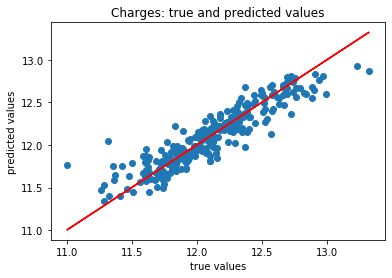

Mean absolute error of the prediction is: 0.11747184712690274
Mean squared error of the prediction is: 0.025045671844994538
Root mean squared error of the prediction is: 0.158258244161227
Mean absolute percentage error of the prediction is: 0.9730359339615163


<IPython.core.display.Javascript object>

In [13]:
# We add constant to the model as it's a best practice
# to do so every time!
X2_test = sm.add_constant(X2_test)

# We are making predictions here
y2_preds = lm2.predict(X2_test)

plt.scatter(y2_test, y2_preds)
plt.plot(y2_test, y2_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y2_test, y2_preds)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds)))
print(
    "Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds))
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100
    )
)

**Is the performance of your model satisfactory? Why?**

Yes, the assessment is above.

**Try to improve your model in terms of predictive performance by adding or removing some variables.**

I already did this in the last assignment, and I have no interest in doing this again and again.